In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import glob
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib import colors
from nilearn.glm.first_level import hemodynamic_models
from nilearn.plotting import plot_roi
from nilearn.image import binarize_img, concat_imgs, mean_img
import statsmodels.api as sm

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

sns.set(font_scale = 1)
sns.set_palette("muted")

### Figure 1

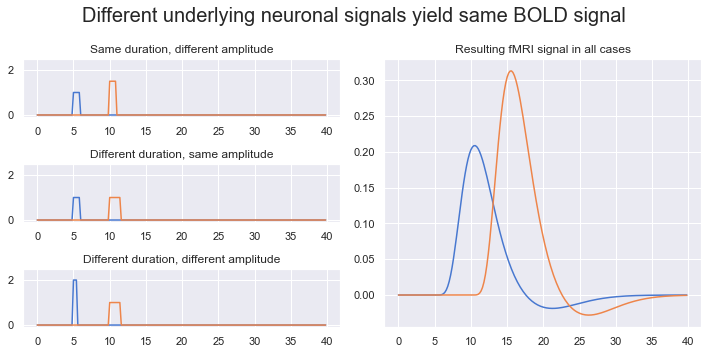

In [2]:
frame_times = np.arange(0, 40, .2)

dur1a = 1
amp1a = 1
dur1b = 1
amp1b = 1.5

dur2a = 1
amp2a = 1
dur2b = 1.5
amp2b = 1

dur3a = .5
amp3a = 2
dur3b = 1.5
amp3b = 1

reg1a, _ = hemodynamic_models.compute_regressor([[5], [dur1a], [amp1a]],
                       'spm', frame_times, oversampling=16)
reg1b, _ = hemodynamic_models.compute_regressor([[10], [dur1b], [amp1b]],
                       'spm', frame_times, oversampling=16)


reg1a_n = frame_times*0
reg1a_n[(frame_times>=5) & (frame_times<(5+dur1a))] = amp1a
reg1b_n = frame_times*0
reg1b_n[(frame_times>=10) & (frame_times<(10+dur1b))] = amp1b
reg2a_n = frame_times*0
reg2a_n[(frame_times>=5) & (frame_times<(5+dur2a))] = amp2a
reg2b_n = frame_times*0
reg2b_n[(frame_times>=10) & (frame_times<(10+dur2b))] = amp2b
reg3a_n = frame_times*0
reg3a_n[(frame_times>=5) & (frame_times<(5+dur3a))] = amp3a
reg3b_n = frame_times*0
reg3b_n[(frame_times>=10) & (frame_times<(10+dur3b))] = amp3b


fig = plt.figure(figsize=(10, 5))
fig.suptitle("Different underlying neuronal signals yield same BOLD signal",
             fontsize=20)
gs = GridSpec(nrows=3, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(frame_times, reg1a_n)
ax0.plot(frame_times, reg1b_n)
ax0.set_ylim(-.1, 2.5)
ax0.set_title("Same duration, different amplitude")

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(frame_times, reg2a_n)
ax1.plot(frame_times, reg2b_n)
ax1.set_ylim(-.1, 2.5)
ax1.set_title("Different duration, same amplitude")

ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(frame_times, reg3a_n)
ax2.plot(frame_times, reg3b_n)
ax2.set_ylim(-.1, 2.5)
ax2.set_title("Different duration, different amplitude")

ax3 = fig.add_subplot(gs[:, 1])
ax3.plot(frame_times, reg1a)
ax3.plot(frame_times, reg1b)
ax3.set_title("Resulting fMRI signal in all cases")
plt.tight_layout()
plt.savefig('/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/neuron_same_bold.pdf')

#### Relationship between RT and BOLD amplitude

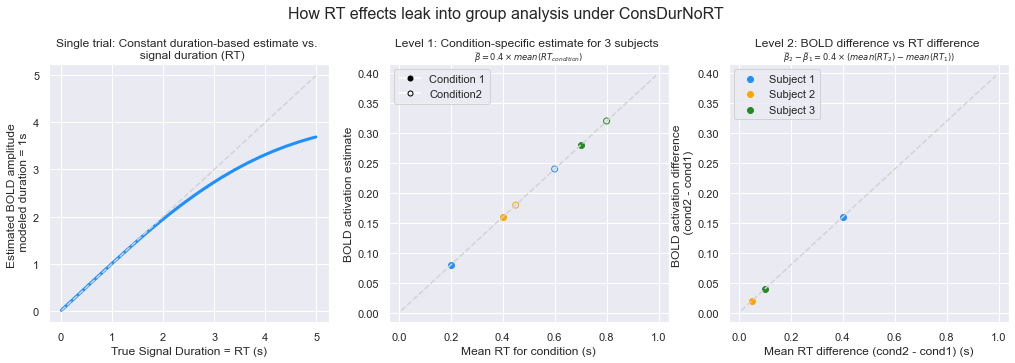

In [19]:
from matplotlib.lines import Line2D


reg_dur_val = 1
true_duration = np.round(np.arange(0.01, 5, .01), 2)
num_durs = len(true_duration)
est_bold_amplitude_1s = np.empty(true_duration.shape)*np.nan
frame_times = np.arange(0, 100, .2)
reg1s, _ = hemodynamic_models.compute_regressor([[5], [reg_dur_val], [1]],
                       'spm', frame_times, oversampling=16)
mod_reg1s = sm.add_constant(reg1s)
for ind, cur_dur in enumerate(true_duration):
    loop_3col_onsets = np.transpose(np.c_[5, cur_dur, 1])
    signal, _ = hemodynamic_models.compute_regressor(loop_3col_onsets,
                       'spm', frame_times, oversampling=16)
    mod_ols = sm.OLS(signal, mod_reg1s).fit() 
    est_bold_amplitude_1s[ind] = mod_ols.params[1]

#RTs for 3 'subjects'
rt_cond1 = np.array([.2, .4, .7])
rt_cond2 = np.array([.6, .45, .8])

#condition effect size (same for both conditions)
B = .4

est_cond1 = B * np.array([est_bold_amplitude_1s[np.where(true_duration == val)][0] for val in rt_cond1])
est_cond2 = B * np.array([est_bold_amplitude_1s[np.where(true_duration == val)][0] for val in rt_cond2])

rt_diff = rt_cond2 - rt_cond1
est_diff = est_cond2 - est_cond1

# For the straight line in panel A
yvals_line_1 = true_duration

xvals_line_B = true_duration[true_duration < 1]
yvals_line_B = B * xvals_line_B

fig, axs = plt.subplots(1,3, figsize = (14, 5))
fig.suptitle('How RT effects leak into group analysis under ConsDurNoRT \n', fontsize=16)

axs[0].plot(true_duration, est_bold_amplitude_1s, color = 'dodgerblue', 
    linewidth=3)
axs[0].plot(true_duration, yvals_line_1, color = 'lightgray', linestyle = 'dashed')
axs[0].set_xlabel("True Signal Duration = RT (s)")
axs[0].set_ylabel("Estimated BOLD amplitude \n modeled duration = 1s")
axs[0].set_title('Single trial: Constant duration-based estimate vs. \n  signal duration (RT)')

axs[1].plot(xvals_line_B, yvals_line_B, color='lightgray', linestyle = 'dashed')
sub_colors = ['dodgerblue', 'orange', 'forestgreen']
for sub in range(3):
    axs[1].scatter(rt_cond1[sub], est_cond1[sub], color=sub_colors[sub], marker='o', label=f'Subject {sub+1}')
    axs[1].scatter(rt_cond2[sub], est_cond2[sub], edgecolors=sub_colors[sub], marker='o', facecolors='none')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Condition 1',
                          markerfacecolor='black', markeredgecolor='black', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Condition2',
                          markerfacecolor='none', markeredgecolor='black', markersize=5)]
axs[1].legend(handles=legend_elements)
axs[1].set_xlabel('Mean RT for condition (s)')
axs[1].set_ylabel('BOLD activation estimate')
axs[1].set_title('Level 1: Condition-specific estimate for 3 subjects \n' r'$_{\widehat\beta = 'f'{B}'r'\times mean(RT_{condition})}$')

axs[2].plot(xvals_line_B, yvals_line_B, color='lightgray', linestyle = 'dashed')
for sub in range(3):
    axs[2].scatter(rt_diff[sub], est_diff[sub], color=sub_colors[sub], marker='o', label=f'Subject {sub+1}')
axs[2].legend()
axs[2].set_xlabel('Mean RT difference (cond2 - cond1) (s)')
axs[2].set_ylabel('BOLD activation difference \n (cond2 - cond1)')
axs[2].set_title('Level 2: BOLD difference vs RT difference \n' r'$_{\widehat\beta_2 - \widehat\beta_1 = 'f'{B}'r'\times (mean(RT_2) - mean(RT_1))}$')



fig.tight_layout()
plt.savefig('/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/bold_fcn_rt_1sdur_only.pdf')

### Type I error plots

In [ ]:
def make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path=None):
    sns.set(font_scale = 1.5)
    colors_tab10 =  sns.color_palette('muted')
    
    fc_dat = pd.read_csv(fc_file)
    stroop_dat = pd.read_csv(stroop_file)
    fc_dat['Settings'] = 'Categorization task-based RTs'
    stroop_dat['Settings'] = 'Stroop task-based RTs'
    dat_all = pd.concat([fc_dat, stroop_dat])

    scale_dictionary={'dv_scales_yes': 'Duration scales with RT',
                  'dv_scales_no': 'Duration does not scale with RT'}
    dat_all = dat_all.replace({"Scale Type": scale_dictionary})
    dat_all = dat_all[dat_all['Data Type'] == 'random']
    model_dictionary = {'Two stimulus types, no RT': 'Mod 1: Constant Duration, no RT',
                     'Two stimulus types, 2 RT dur only': 'Mod 2: RT Duration',
                     'Two stimulus types, RT mod': 'Mod 3: Constant Duration, RTMod',
                     'Two stimulus types, 2cons, 1 RT dur': 'Mod 4: Constant Duration, RTDur',
                     'Two stimulus types, RTmod interaction, con main': 'Mod 5: Main effect RTMod interaction model',
                     'Two stimulus types, RTDur interaction, con main': 'Mod 6: Main effect RTDur interaction model',
                     'Two stimulus types, RTmod interaction, con int': 'Mod 5: Interaction effect RTMod interaction model',
                     'Two stimulus types, RTDur interaction, con int': 'Mod 6: Interaction effect RTDur interaction model'}
    model_names = np.array(list(model_dictionary.values()))
    if plot_type == 'type1err':
        mod_inds = [0, 1, 2, 3]
        colors = [colors_tab10[i] for i in mod_inds]
        sns.set_palette(sns.color_palette(colors))
        color_hue_order = model_names[mod_inds]
        dat_all = dat_all.replace({"Model": model_dictionary})
        g = sns.relplot(data = dat_all, x='RT diff', y='Rejection Rate', 
                hue = 'Model', col = 'Scale Type', row = 'Settings',
                kind = 'line', hue_order = color_hue_order, height=5, aspect=1.5,
                size = 'Model', sizes=(2, 5),
                size_order=color_hue_order).set_titles("{row_name} \n {col_name}").set_axis_labels('RT difference', 'Error rate')
    if plot_type == 'corr':
        mod_inds = [0, 1, 2, 3]
        colors = [colors_tab10[i] for i in mod_inds]
        sns.set_palette(sns.color_palette(colors))
        color_hue_order = model_names[mod_inds]
        dat_all = dat_all.replace({"Model": model_dictionary})
        g = sns.relplot(data = dat_all, x='RT diff', y='Correlation (beta diff with rt diff)', 
            hue = 'Model', col = 'Scale Type', row = 'Settings',
            kind = 'line', hue_order = color_hue_order, height=5, aspect=1.5,
            size = 'Model', sizes=(2, 5),
            size_order=color_hue_order).set_titles("{row_name} \n {col_name}").set_axis_labels("RT difference", "Correlation (contrast with RT diff)")
    if plot_type == 'power_2stage_cond_diff':
        mod_inds = [2, 4]
        colors = [colors_tab10[i] for i in mod_inds]
        sns.set_palette(sns.color_palette(colors))
        color_hue_order = model_names[mod_inds]    
        dat_all = dat_all.replace({"Model": model_dictionary})   
        dat_all = dat_all[(~dat_all['Rejection Rate (2 step)'].isnull()) & (dat_all['Scale Type'] == "Duration does not scale with RT")]
        g = sns.relplot(data = dat_all[dat_all['Beta Contrast'] == 'beta_diff_est'], x='Beta diff', y='Rejection Rate (2 step)', 
            hue = 'Model', col = 'Scale Type', row = 'Settings',
            kind = 'line', hue_order = color_hue_order, height=5, aspect=1.5, size = 'Model', sizes=(2, 5),
            size_order=color_hue_order).set_titles("{row_name} \n {col_name}").set_axis_labels("Beta difference", "Power")
    if 'power_all' in plot_type:
        dat_all = dat_all.replace({"Model": model_dictionary})
        if plot_type == 'power_all_rt_lt2':
            mod_inds_scales_no = [0, 2, 3]
            model_names_scales_no = model_names[mod_inds_scales_no]
            mod_inds_scales_yes = [1, 2, 3, 6, 7]
            model_names_scales_yes = model_names[mod_inds_scales_yes]
            mod_inds = [0, 1, 2, 3, 6, 7]
        if plot_type == 'power_all_rt_gt2':
            mod_inds_scales_no = [0, 3]
            model_names_scales_no = model_names[mod_inds_scales_no]
            mod_inds_scales_yes = [1, 3, 7]
            model_names_scales_yes = model_names[mod_inds_scales_yes]
            mod_inds = [0, 1, 3, 7]

        colors = [colors_tab10[i] for i in mod_inds]
        sns.set_palette(sns.color_palette(colors))
        color_hue_order = model_names[mod_inds]
        dat_all = dat_all[((dat_all['Scale Type'] == 'Duration does not scale with RT') & (dat_all['Model'].isin(model_names_scales_no))) |
                        ((dat_all['Scale Type'] == 'Duration scales with RT') & (dat_all['Model'].isin(model_names_scales_yes)))]
        g = sns.relplot(data = dat_all[(dat_all['Beta Contrast'] == 'beta_diff_est')], 
                x='Beta diff', y='Rejection Rate', 
                hue = 'Model', col = 'Scale Type', row = 'Settings',
                kind = 'line', hue_order = color_hue_order, height=5, aspect=1.5,
                size = 'Model', sizes=(2, 5),
                size_order=color_hue_order).set_titles("{row_name} \n {col_name}").set_axis_labels('Beta difference', 'Power')
        
    if fig_path:
        plt.savefig(fig_path)



#### ISI = (2, 4)

In [ ]:
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/revisions'

fc_file = (f'{outdir}/group_type1_err_corr_by_rtdiff_'
    f'output_nsim1000_nsub100_mu638_btwn_noise0.650.75_isi2_4_revisions.csv')
stroop_file = (f'{outdir}/group_type1_err_corr_by_rtdiff_'
    f'output_nsim1000_nsub100_mu530_btwn_noise0.650.6_isi2_4_revisions.csv')
plot_type = 'type1err'
fig_path = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/type1_err_24_rev.pdf'

make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path)


In [ ]:
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/revisions'

fc_file = (f'{outdir}/group_type1_err_corr_by_rtdiff_'
    f'output_nsim1000_nsub100_mu638_btwn_noise0.650.75_isi3_6_revisions.csv')
stroop_file = (f'{outdir}/group_type1_err_corr_by_rtdiff_'
    f'output_nsim1000_nsub100_mu530_btwn_noise0.650.6_isi3_6_revisions.csv')
plot_type = 'type1err'
fig_path = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/type1_err_36_rev.pdf'

make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path)

### Power


### Power for interaction models
#### Two stage procedure to test condition difference

In [ ]:
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/revisions'

fc_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu638_btwn_noise0.650.75_isi2_4_rtdiff_0.1_revisions.csv')
stroop_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu530_btwn_noise0.650.6_isi2_4_rtdiff_0.1_revisions.csv')

plot_type = 'power_2stage_cond_diff'
fig_path = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/power_24_rtdiff_1_interaction_main_effect_rev.pdf'

make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path)

### Power for Scales with and doesn't scale with RT 

RT < 2s

In [ ]:
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/revisions'

fc_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu638_btwn_noise0.650.75_isi2_4_rtdiff_0.1_revisions.csv')
stroop_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu530_btwn_noise0.650.6_isi2_4_rtdiff_0.1_revisions.csv')

plot_type = 'power_all_rt_lt2'
fig_path = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/power_24_rtdiff_1_all_rev.pdf'

make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path)

In [ ]:
#ISI = (3,6)
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/revisions'

fc_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu638_btwn_noise0.650.75_isi3_6_rtdiff_0.1_revisions.csv')
stroop_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu530_btwn_noise0.650.6_isi3_6_rtdiff_0.1_revisions.csv')

plot_type = 'power_all_rt_lt2'
fig_path = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/power_36_rtdiff_1_all_rev.pdf'

make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path)

RT>2s

In [ ]:
#ISI = (2,4), RTdiff = 0.8
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/revisions'

fc_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu638_btwn_noise0.650.75_isi2_4_rtdiff_0.8_revisions.csv')
stroop_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu530_btwn_noise0.650.6_isi2_4_rtdiff_0.8_revisions.csv')

plot_type = 'power_all_rt_gt2'
fig_path = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/power_24_rtdiff_8_all_rev.pdf'

make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path)

In [ ]:
#ISI = (3,6), RTdiff = 0.8
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/revisions'

fc_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu638_btwn_noise0.650.75_isi3_6_rtdiff_0.8_revisions.csv')
stroop_file = (f'{outdir}/group_power_output_nsim1000_nsub100_mu530_btwn_noise0.650.6_isi3_6_rtdiff_0.8_revisions.csv')

plot_type = 'power_all_rt_gt2'
fig_path = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/power_36_rtdiff_8_all_rev.pdf'

make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path)

### Correlation plots

In [ ]:
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/revisions'
fc_file = (f'{outdir}/group_type1_err_corr_by_rtdiff_'
    f'output_nsim1000_nsub100_mu638_btwn_noise0.650.75_isi2_4_revisions.csv')
stroop_file = (f'{outdir}/group_type1_err_corr_by_rtdiff_'
    f'output_nsim1000_nsub100_mu530_btwn_noise0.650.6_isi2_4_revisions.csv')
plot_type = 'corr'
fig_path = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/cor_with_rt_rev.pdf'

make_power_t1err_plots(fc_file, stroop_file, plot_type, fig_path)

#### Conjunction figure

In [ ]:
#outdir = '/Users/jeanettemumford/sherlock_local/data/uh2/aim1_mumford/output'
outdir = '/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Output/group_models'
files_for_conjunction = glob.glob(
    f'{outdir}/*lev2*/*contrast_response_time*one_sampt/'
    '*corrp_fstat*'
)

dat_4d = concat_imgs(files_for_conjunction)
dat_4d_bin = binarize_img(dat_4d, threshold = 0.95)
dat_bin_avg = mean_img(dat_4d_bin)
dat_conj = binarize_img(dat_bin_avg, threshold = 1)

In [ ]:
cmap_orange = colors.ListedColormap(['darkorange'])

slice_nums = tuple(np.arange(-25, 65, 5))

fig, axs = plt.subplots(3, figsize=(10, 8))
for i in range(3):
    plot_roi(dat_conj, alpha=1, view_type='continuous', 
        display_mode='z', cut_coords = slice_nums[(0+i*6):(6+i*6)], 
        annotate=True, cmap=cmap_orange, axes=axs[i])
    
plt.savefig('/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/'
    'conjunction_avg_rt_effect_across_7tasks_3row_plot.pdf')

### Illustration for understanding the adjusted vs unadjusted result differences

In [ ]:
sns.set(font_scale = 1)

range_rts1 = [1, 1.5]
mn_rt1 = np.mean(np.array(range_rts1))
range_rts2 = [2, 2.5]
mn_rt2 = np.mean(np.array(range_rts2))

rts_x = np.linspace(0, 4)
slope = 2
line1 = -.5 + slope * rts_x
line2 = 1 + slope * rts_x

fig, axs = plt.subplots(2,2, figsize = (11, 8))
fig.suptitle('Direction of change varies in different \n When ConsDurRT is correct', fontsize=16)
axs[0,0].arrow(0, 0, 0, 8.5, color='darkgray',  linewidth=2, head_width=.1, head_length=.25)
axs[0,0].arrow(0, 0, 4, 0, color='darkgray', linewidth=2, head_width=.25, head_length=.1)
axs[0,0].plot([mn_rt1, mn_rt1], [0, -.5 + slope*mn_rt1], color='forestgreen', alpha = .5, linestyle='dashed')
axs[0,0].plot([mn_rt2, mn_rt2], [0, 1 + slope*mn_rt2], color='orange', alpha = .5, linestyle='dashed')
axs[0,0].plot(rts_x, line1, color='forestgreen')
axs[0,0].plot(rts_x, line2, color='orange')
axs[0,0].plot(range_rts1, [0, 0], color='forestgreen', alpha=.5, linewidth=4)
axs[0,0].plot(range_rts2, [0, 0], color='orange', alpha=.5, linewidth=4)
axs[0,0].plot([4, 4], [-.5 + slope*mn_rt1, 1 + slope*mn_rt2], color='darkred', alpha = .5)
axs[0,0].text(3.15, 4, 'Unadjusted \n difference')
axs[0,0].plot([4, 4], [-.5 + slope*4, 1 + slope*4], color='darkred', alpha = .5)
axs[0,0].text(3.15, 7.5, 'Adjusted \n difference')
axs[0,0].set_title('0 < Adjusted difference < Unadjusted difference')

range_rts2 = [1, 1.5]
mn_rt2 = np.mean(np.array(range_rts2))
range_rts1 = [2, 2.5]
mn_rt1 = np.mean(np.array(range_rts1))

axs[0,1].arrow(0, 0, 0, 8.5, color='darkgray',  linewidth=2, head_width=.1, head_length=.25)
axs[0,1].arrow(0, 0, 4, 0, color='darkgray', linewidth=2, head_width=.25, head_length=.1)
axs[0,1].plot([mn_rt1, mn_rt1], [0, -.5 + slope*mn_rt1], color='forestgreen', alpha = .5, linestyle='dashed')
axs[0,1].plot([mn_rt2, mn_rt2], [0, 1 + slope*mn_rt2], color='orange', alpha = .5, linestyle='dashed')
axs[0,1].plot(rts_x, line1, color='forestgreen')
axs[0,1].plot(rts_x, line2, color='orange')
axs[0,1].plot(range_rts1, [0, 0], color='forestgreen', alpha=.5, linewidth=4)
axs[0,1].plot(range_rts2, [0, 0], color='orange', alpha=.5, linewidth=4)
axs[0,1].plot([4, 4], [-.5 + slope*mn_rt1, 1 + slope*mn_rt2], color='dodgerblue', alpha = .5)
axs[0,1].text(3.15, 4, 'Unadjusted \n difference')
axs[0,1].plot([4, 4], [-.5 + slope*4, 1 + slope*4], color='darkred', alpha = .5)
axs[0,1].text(3.15, 7.5, 'Adjusted \n difference')
axs[0,1].set_title('Adjusted difference > 0 > Unadjusted difference')

range_rts1 = [1, 1.5]
mn_rt1 = np.mean(np.array(range_rts1))
range_rts2 = [2, 2.5]
mn_rt2 = np.mean(np.array(range_rts2))

axs[1,0].arrow(0, 0, 0, 8.5, color='darkgray',  linewidth=2, head_width=.1, head_length=.25)
axs[1,0].arrow(0, 0, 4, 0, color='darkgray', linewidth=2, head_width=.25, head_length=.1)
axs[1,0].plot([mn_rt1, mn_rt1], [0, -.5 + slope*mn_rt1], color='orange', alpha = .5, linestyle='dashed')
axs[1,0].plot([mn_rt2, mn_rt2], [0, 1 + slope*mn_rt2], color='forestgreen', alpha = .5, linestyle='dashed')
axs[1,0].plot(rts_x, line1, color='orange')
axs[1,0].plot(rts_x, line2, color='forestgreen')
axs[1,0].plot(range_rts1, [0, 0], color='orange', alpha=.5, linewidth=4)
axs[1,0].plot(range_rts2, [0, 0], color='forestgreen', alpha=.5, linewidth=4)
axs[1,0].plot([4, 4], [-.5 + slope*mn_rt1, 1 + slope*mn_rt2], color='dodgerblue', alpha = .5)
axs[1,0].text(3.15, 4, 'Unadjusted \n difference')
axs[1,0].plot([4, 4], [-.5 + slope*4, 1 + slope*4], color='dodgerblue', alpha = .5)
axs[1,0].text(3.15, 7.5, 'Adjusted \n difference')
axs[1,0].set_title('Undjusted difference < Adjusted difference < 0')

range_rts2 = [1, 1.5]
mn_rt2 = np.mean(np.array(range_rts2))
range_rts1 = [2, 2.5]
mn_rt1 = np.mean(np.array(range_rts1))

axs[1,1].arrow(0, 0, 0, 8.5, color='darkgray',  linewidth=2, head_width=.1, head_length=.25)
axs[1,1].arrow(0, 0, 4, 0, color='darkgray', linewidth=2, head_width=.25, head_length=.1)
axs[1,1].plot([mn_rt1, mn_rt1], [0, -.5 + slope*mn_rt1], color='orange', alpha = .5, linestyle='dashed')
axs[1,1].plot([mn_rt2, mn_rt2], [0, 1 + slope*mn_rt2], color='forestgreen', alpha = .5, linestyle='dashed')
axs[1,1].plot(rts_x, line1, color='orange')
axs[1,1].plot(rts_x, line2, color='forestgreen')
axs[1,1].plot(range_rts1, [0, 0], color='orange', alpha=.5, linewidth=4)
axs[1,1].plot(range_rts2, [0, 0], color='forestgreen', alpha=.5, linewidth=4)
axs[1,1].plot([4, 4], [-.5 + slope*mn_rt1, 1 + slope*mn_rt2], color='darkred', alpha = .5)
axs[1,1].text(3.15, 4, 'Unadjusted \n difference')
axs[1,1].plot([4, 4], [-.5 + slope*4, 1 + slope*4], color='dodgerblue', alpha = .5)
axs[1,1].text(3.15, 7.5, 'Adjusted \n difference')
axs[1,1].set_title('Adjusted difference < 0 < Unadjusted difference')
fig.tight_layout()
plt.show()

fig.tight_layout()
plt.show()

### Relationship between RTDur and ConsDurRTDur

In [ ]:
#rt_cond1 = np.atleast_2d(np.sort(np.random.uniform(.5, 1.5, 5)))
#rt_cond2 = np.atleast_2d(np.sort(np.random.uniform(2, 4, 5)))
rt_cond1 = np.atleast_2d(np.linspace(.5, 1.2, num=5))
rt_cond2 = np.atleast_2d(np.linspace(2.5, 3.5, num=5))
rt_all = np.atleast_2d(np.concatenate((rt_cond1, rt_cond2), axis=1))

onsets = np.atleast_2d(np.arange(10))*20
cons = np.atleast_2d(np.ones(10))
cons_half = np.atleast_2d(np.ones(5))

frame_times = np.arange(np.max(onsets) + 15)

rtdur1_3col = np.concatenate((onsets[:, :5], rt_cond1, cons_half))
rtdur2_3col = np.concatenate((onsets[:, 5:], rt_cond2, cons_half))

cons_dur1_3col = np.concatenate((onsets[:, :5], cons_half, cons_half))
cons_dur2_3col = np.concatenate((onsets[:, 5:], cons_half, cons_half))
rtdur_all_3col = np.concatenate((onsets, rt_all, cons))

rtdur1, _ = hemodynamic_models.compute_regressor(rtdur1_3col, 'spm', frame_times, oversampling=16)
rtdur2, _ = hemodynamic_models.compute_regressor(rtdur2_3col, 'spm', frame_times, oversampling=16)

cons_dur1, _ = hemodynamic_models.compute_regressor(cons_dur1_3col, 'spm', frame_times, oversampling=16)
cons_dur2, _ = hemodynamic_models.compute_regressor(cons_dur2_3col, 'spm', frame_times, oversampling=16)
rtdur_all, _ = hemodynamic_models.compute_regressor(rtdur_all_3col, 'spm', frame_times, oversampling=16)


In [ ]:
y = 1 + 1*rtdur1 + 4*rtdur2 

cons_dur_rt_dur_des = pd.DataFrame({'constant': 1, 'cons_dur1': cons_dur1[:,0], 'cons_dur2': cons_dur2[:,0], 'rtdur_all': rtdur_all[:,0]})
rt_dur_des = pd.DataFrame({'constant': 1, 'rtdur1': rtdur1[:,0], 'rtdur2': rtdur2[:,0]})


mod_cons_dur_rt_dur = sm.OLS(y, cons_dur_rt_dur_des)
results_cons_dur_rt_dur = mod_cons_dur_rt_dur.fit()
print(results_cons_dur_rt_dur.summary(slim=True))
print(results_cons_dur_rt_dur.params)

mod_rtdur = sm.OLS(y, rt_dur_des)
results_rtdur = mod_rtdur.fit()
print(results_rtdur.summary(slim=True))
print(results_rtdur.params)


In [ ]:
sns.set(font_scale = 1)

betas_cons_dur_rt = results_cons_dur_rt_dur.params
betas_rt_dur = results_rtdur.params


In [ ]:

fig, axs = plt.subplots(1,3, figsize = (15, 7))
plt.setp(axs, ylim=(-.6, 4))
axs[0].plot(frame_times, y, linewidth=3, alpha=.6, color = 'dimgrey')
axs[0].plot(frame_times, betas_cons_dur_rt['constant'] + rtdur_all*betas_cons_dur_rt['rtdur_all'], color='forestgreen')
axs[0].set_title(r'$\widehat\beta_0 + \widehat\beta_3RTDur$')
axs[0].legend(['BOLD Data (under RTDur)', r'$\widehat\beta_0 + \widehat\beta_3RTDur$'] )
axs[1].plot(frame_times, y, linewidth=3, alpha=.6, color = 'dimgrey')
axs[1].plot(frame_times, betas_cons_dur_rt['cons_dur1']* cons_dur1, color='orange')
axs[1].plot(frame_times, betas_cons_dur_rt['cons_dur2']* cons_dur2, color='dodgerblue')
axs[1].set_title(r'$\widehat\beta_1Cond1$ and $\widehat\beta_2Cond2$')
axs[1].legend(['BOLD Data (under RTDur)', r'$\widehat\beta_1Cond1$', r'$\widehat\beta_2Cond2$'] )
axs[2].plot(frame_times, y, linewidth=3, alpha=.6, color = 'dimgrey')
axs[2].plot(frame_times, betas_cons_dur_rt['constant'] + rtdur_all*betas_cons_dur_rt['rtdur_all'] +  betas_cons_dur_rt['cons_dur1']* cons_dur1 + betas_cons_dur_rt['cons_dur2']* cons_dur2, color='black')
axs[2].set_title(r'$\widehat\beta_0 + \widehat\beta_1Cond1 + \widehat\beta_2Cond2 + \widehat\beta_3RTDur$')
axs[2].legend(['BOLD Data (under RTDur)', r'$\widehat\beta_0 + \widehat\beta_1Cond1 + \widehat\beta_2Cond2 + \widehat\beta_3RTDur$'], loc=2 )
fig.tight_layout()
plt.savefig('/Users/jeanettemumford/Dropbox/Research/Projects/rt_paper_code/Figures/'
    'ConsDurRT_fit_explanation.pdf')